In [151]:
from itertools import combinations
from typing import TypeAlias
from pprint import pprint
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [59]:
Weights: TypeAlias = jax.Array

In [55]:
SEED = 42
key = jax.random.PRNGKey(SEED)

In [7]:
# Pegando o conjunto de dados
X, y = load_iris(return_X_y=True)
X, y = jnp.array(X), jnp.array(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y
)

In [69]:
INPUT_DIM = X.shape[1]
OUTPUT_DIM = len(jnp.unique(y))

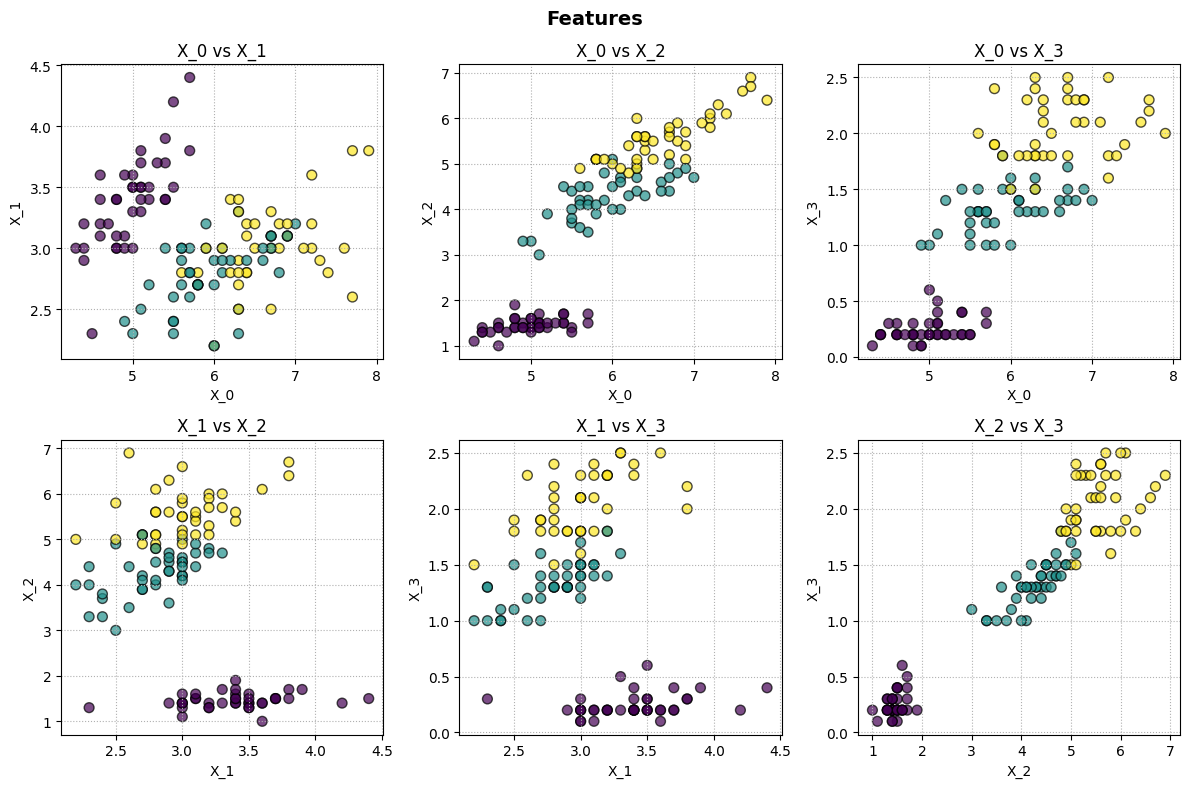

In [62]:
pairs = list(combinations(range(INPUT_DIM), 2))

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for ax, (i, j) in zip(axes, pairs):
    scatter = ax.scatter(
        X_train[:, i], 
        X_train[:, j],
        c=y_train,
        marker='o',
        alpha=0.7,
        edgecolor='k',
        s=50
    )
    ax.set_xlabel(f"X_{i}")
    ax.set_ylabel(f"X_{j}")
    ax.set_title(f"X_{i} vs X_{j}")
    ax.grid(True, linestyle=':')

fig.suptitle('Features', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [74]:
# iniciando os pesos e bias do nosso modelo
def init_params(
    key: jax.random.PRNGKey,
    input_dim: int = INPUT_DIM,
    output_dim: int = OUTPUT_DIM
) -> dict[str, Weights]:
    k1, k2, k3 = jax.random.split(key, 3)
    return {
        # 1º camada
        'W1': jax.random.normal(k1, (input_dim, 8)),
        'b1': jnp.zeros((8,)),
        # 2º camada
        'W2': jax.random.normal(k2, (8, 4)),
        'b2': jnp.zeros((4,)),
        # 3º camada
        'W3': jax.random.normal(k3, (4, output_dim)),
        'b3': jnp.zeros((output_dim,)),
    }

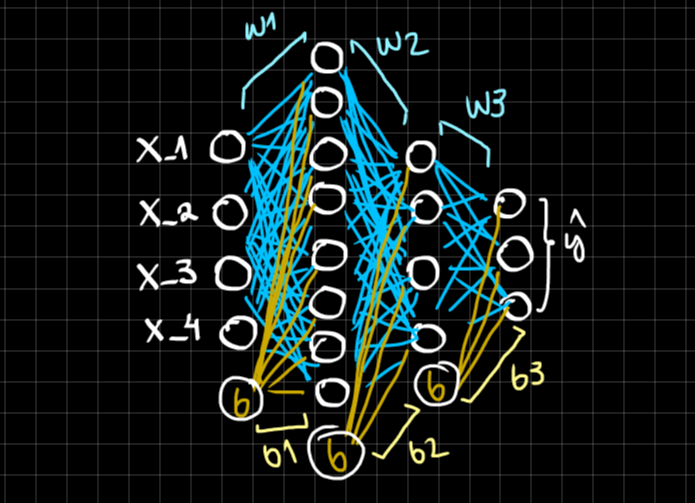

In [153]:
params = init_params(key)
# os pesos do nosso modelo inicializados
pprint(params)

{'W1': Array([[ 7.5925536e-02, -4.8634264e-01,  1.2903206e+00,  5.1961190e-01,
         3.0040437e-01,  3.1034866e-01,  5.7616091e-01, -8.0746210e-01],
       [-1.9883217e+00,  6.3952953e-01,  2.1763174e-01,  2.4742517e-03,
         1.6645706e+00,  2.0313536e-01, -2.1382248e-02, -6.8679047e-01],
       [ 1.9224519e-02,  4.7158983e-01, -8.4080535e-01,  1.0207201e+00,
        -2.1002991e+00,  4.3098864e-01, -6.9074976e-01,  1.0829577e+00],
       [ 1.9644964e-01,  8.5078067e-01,  1.8178146e+00,  7.1369797e-01,
         1.3108276e+00, -1.5812742e+00,  1.4576868e-03, -2.5948390e-01]],      dtype=float32),
 'W2': Array([[ 0.60576403,  0.7990441 , -0.908927  , -0.63525754],
       [-1.2226585 , -0.83226097, -0.47417238, -1.2504351 ],
       [-0.17678244, -0.04917514, -0.41177532, -0.39363015],
       [ 1.3116323 ,  0.21555556,  0.41164538, -0.28955024],
       [-0.96516913,  0.4492738 , -0.4404279 , -0.92797494],
       [-0.27167085,  0.6813305 , -0.48514158,  0.5080369 ],
       [-0.1429046

In [93]:
# forward pass
def forward(params, X) -> jax.Array:
    input_layer = jax.nn.gelu(X @ params['W1'] + params['b1'])
    hidden_layer = jax.nn.gelu(input_layer @ params['W2'] + params['b2'])
    logits = (hidden_layer @ params['W3'] + params['b3'])
    return logits

In [106]:
def loss_fn(params, X, y):
    logits = forward(params, X)
    log_probs = jax.nn.log_softmax(logits, axis=-1)
    loss = -log_probs[jnp.arange(y.shape[0]), y]
    return jnp.mean(loss)

In [108]:
@jax.jit
def update(params, opt_state, X, y):
    loss, grads = jax.value_and_grad(loss_fn)(params, X, y)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

In [109]:
LR = 1e-3
optimizer = optax.sgd(learning_rate=LR)

In [116]:
opt_state = optimizer.init(params)

In [117]:
EPOCHS = 50_000
for epoch in range(EPOCHS):
    params, opt_state, loss = update(params, opt_state, X_train, y_train)
    if epoch % 5_000 == 0:
        print(f"step ={epoch:6d}, loss ={loss:10.6f}")
        epoch += 1

step =     0, loss =  5.588152
step =  5000, loss =  0.468440
step = 10000, loss =  0.348101
step = 15000, loss =  0.277034
step = 20000, loss =  0.230730
step = 25000, loss =  0.198735
step = 30000, loss =  0.175662
step = 35000, loss =  0.158371
step = 40000, loss =  0.144962
step = 45000, loss =  0.134252


In [152]:
# pesos finais do nosso modelo
pprint(params)

{'W1': Array([[ 0.07587445, -0.2627363 ,  1.3495677 ,  0.3460214 ,  0.3558562 ,
         0.4674808 ,  0.5932257 , -0.765369  ],
       [-1.9883187 ,  0.07283129,  0.27238956,  0.04126723,  2.2292416 ,
         0.8027344 ,  0.07605062, -0.63245153],
       [ 0.01933285,  1.0181974 , -0.8153406 ,  0.7948981 , -2.1257272 ,
         0.24424474, -0.80796146,  1.1197408 ],
       [ 0.19654569,  0.98030365,  1.7875658 ,  0.7552743 ,  0.89251596,
        -1.7714164 , -0.09811441, -0.25594902]], dtype=float32),
 'W2': Array([[ 0.60576403,  0.7990441 , -0.908927  , -0.63525754],
       [-1.2464364 , -1.1242963 , -0.48558962, -1.2504351 ],
       [-0.12986732,  0.1777207 , -0.43599197, -0.39178473],
       [ 1.1262823 , -0.1457802 ,  0.3884074 , -0.28883034],
       [-0.9128702 ,  1.4722497 , -0.44053507, -0.92681706],
       [-0.42670423,  1.3149151 , -0.4934985 ,  0.50905234],
       [-0.1338832 ,  0.45333162,  0.7369747 ,  1.2528682 ],
       [ 0.81677765, -1.1802648 , -0.6800848 , -1.5656278 

In [125]:
y_hat = forward(params, X_test)
y_hat = jnp.argmax(y_hat, axis=1)

In [133]:
print(f'{y_hat}')
print(f'{y_test}')

[2 2 2 1 0 1 1 0 2 1 0 0 1 2 1 1 2 0 0 0 2 2 2 1 0 2 0 1 0 2]
[1 2 2 1 0 1 1 0 2 1 0 0 1 2 1 1 2 0 0 0 2 2 2 1 0 2 0 1 0 2]


In [147]:
def accuracy_fn(y_true: jax.Array, y_pred: jax.Array):
    acc = jnp.mean(y_true == y_pred)
    return round(float(acc), 3)

In [149]:
print(f'Acc: {accuracy_fn(y_test, y_hat)}')

Acc: 0.967


In [ ]:
#